In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#reusable code to dynamically clean outliers from the data set. Function loops through all columns and replaces values SD > 3 with median
def handle_outliers(df, threshold=3):
    #select only numeric cols
    numeric_cols = df.select_dtypes(include=[np.number])
    #get z score from numpy
    z_scores = np.abs(stats.zscore(numeric_cols))
    #create boolean dataframe of is an outlier
    outliers = pd.DataFrame(z_scores > threshold, columns=numeric_cols.columns)

    # Print number of outliers per column
    print("Number of outliers per column:")
    print(outliers.sum(axis=0))
    #focus on this one because it's the only one

    #replace outliers with median
    for i, col in enumerate(numeric_cols):
        median = df[col].median()
        df.loc[outliers[col], col] = median
    return df


In [4]:
#simple boxplot with all the features to visually inspect outliers
def boxplot(df):
    plt.figure(figsize=(12, 8))
    df.boxplot(column=['RSI', 'News Sentiment', 'Forward EPS Estimate', 'Economic Index', 'Commodities Price Index', 'Average Precipitation over last month'])
    plt.grid(True)
    plt.show()


In [32]:
file_path = r'E:\PycharmProjects\TradingExam\Data Intel Project - Data Only.xlsx'

In [33]:
#standard confirmations from import. Can see outliers
data = pd.read_excel(file_path, sheet_name='Returns Static')
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Date                                   1095 non-null   datetime64[ns]
 1   Stock Market                           781 non-null    float64       
 2   RSI                                    781 non-null    float64       
 3   News Sentiment                         1095 non-null   float64       
 4   Forward EPS Estimate                   781 non-null    float64       
 5   Economic Index                         781 non-null    float64       
 6   Commodities Price Index                781 non-null    float64       
 7   Average Precipitation over last month  36 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.6 KB
None
                      Date  Stock Market         RSI  News Sentiment  \
count  

In [34]:
#create a copy of the data to start cleaning up
df = data.copy()
#fill the blanks with the last known value initially (we'll not continue this approach later, but originally there was a mix of weekend/monthly data that we want to test). This will keep Friday's stock price over the weekend until second round of ML
df = df.ffill()
df = df.iloc[2:].reset_index(drop=True)

In [35]:
#sanity check to make sure we can start testing
print(df.isnull().sum())

Date                                     0
Stock Market                             0
RSI                                      0
News Sentiment                           0
Forward EPS Estimate                     0
Economic Index                           0
Commodities Price Index                  0
Average Precipitation over last month    0
dtype: int64


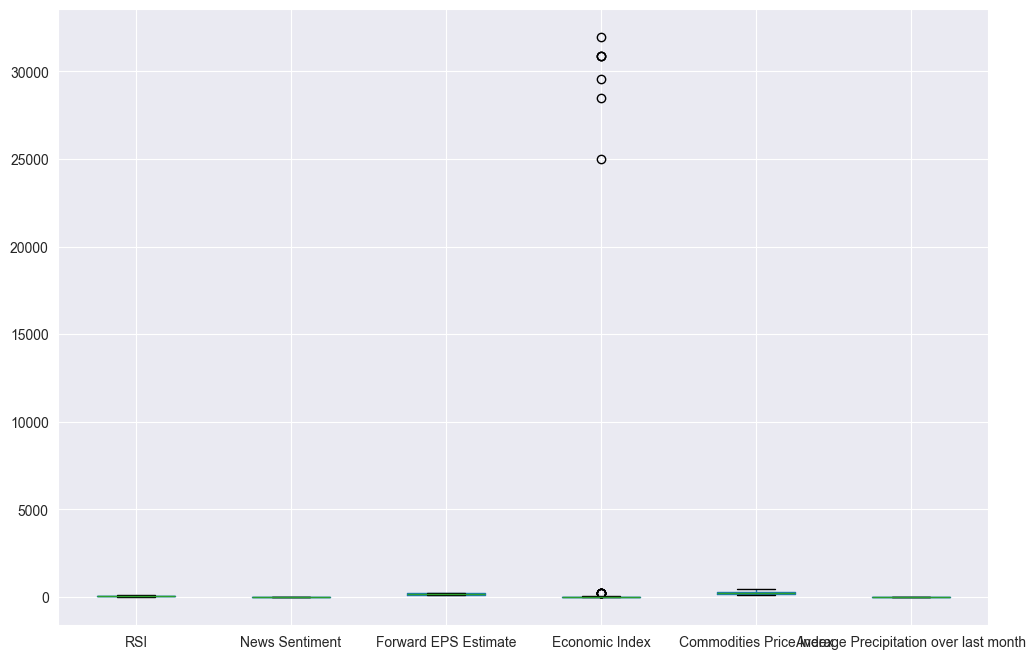

In [36]:
#can see nicely the issue with economic index
boxplot(df)

In [37]:
#clean up the data
df = handle_outliers(df)

Number of outliers per column:
Stock Market                             0
RSI                                      0
News Sentiment                           0
Forward EPS Estimate                     0
Economic Index                           7
Commodities Price Index                  0
Average Precipitation over last month    0
dtype: int64


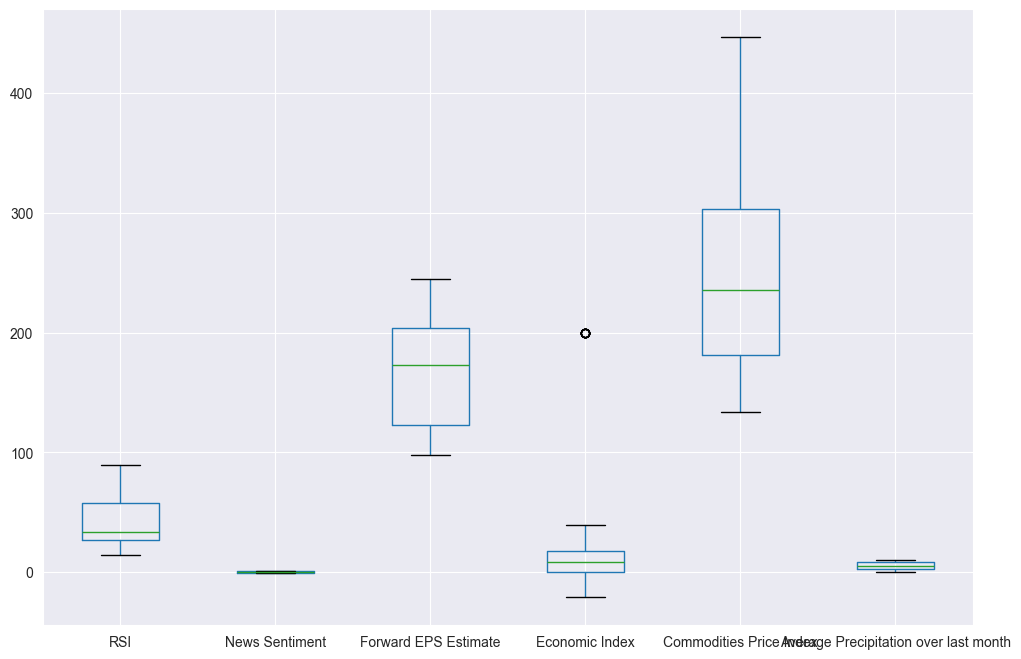

In [38]:
#check it worked. We have 1 outlier left, we'll test data for now and clean again later
boxplot(df)

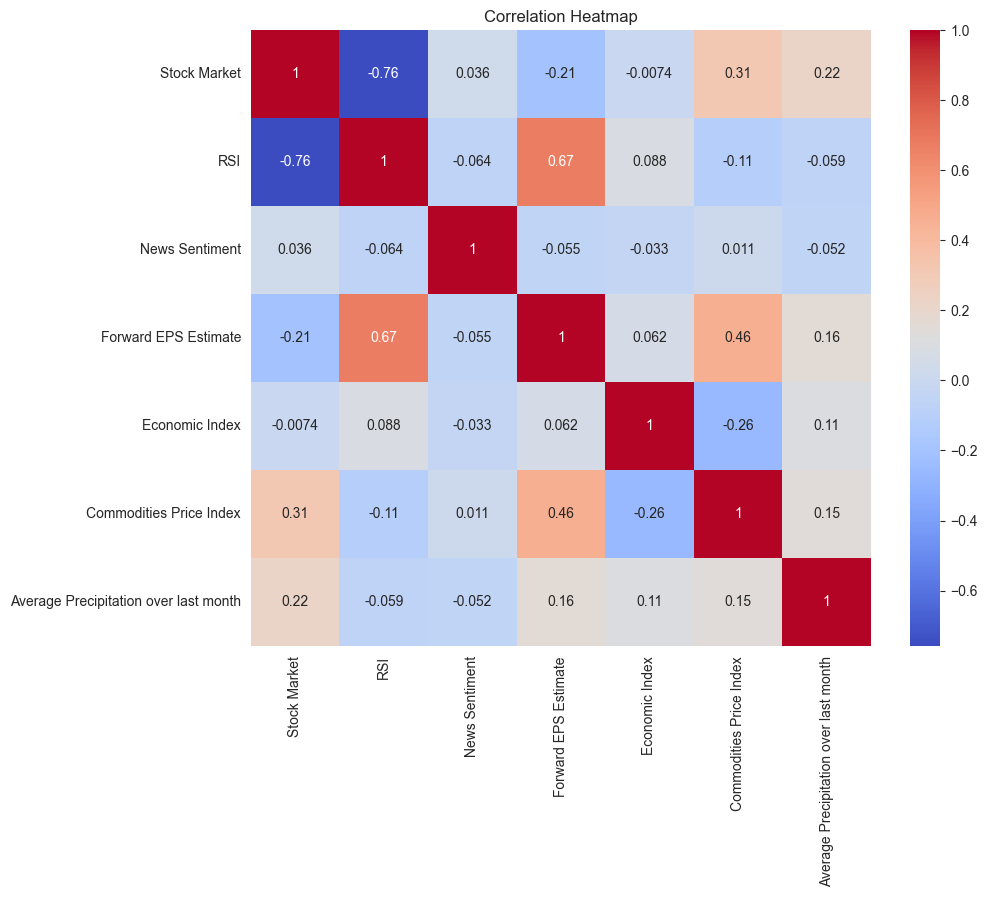

In [39]:
#simple heat map of correlations to see if any features have simple relationships we can go after
numeric_cols = df.select_dtypes(include=[np.number])
correlation_matrix = df[numeric_cols.columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [40]:
#RSI was good and we'll come back to that. Going to use gradient boosting and feature optimisation and see what the initial sweep looks like

#use all the features so we can rank them
#features = ['RSI', 'News Sentiment', 'Forward EPS Estimate', 'Economic Index', 'Commodities Price Index', 'Average Precipitation over last month']
features = ['News Sentiment', 'Economic Index', 'Commodities Price Index', 'Average Precipitation over last month']

X = df[features]
Y = df['Stock Market']

#20% train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [41]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
y_pred = model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error: %.3f" % mse)
print("R-squared: %.3f" % r2)

#coming out with 99.3% R squared. Obviously overfit


Mean squared error: 100024.838
R-squared: 0.957


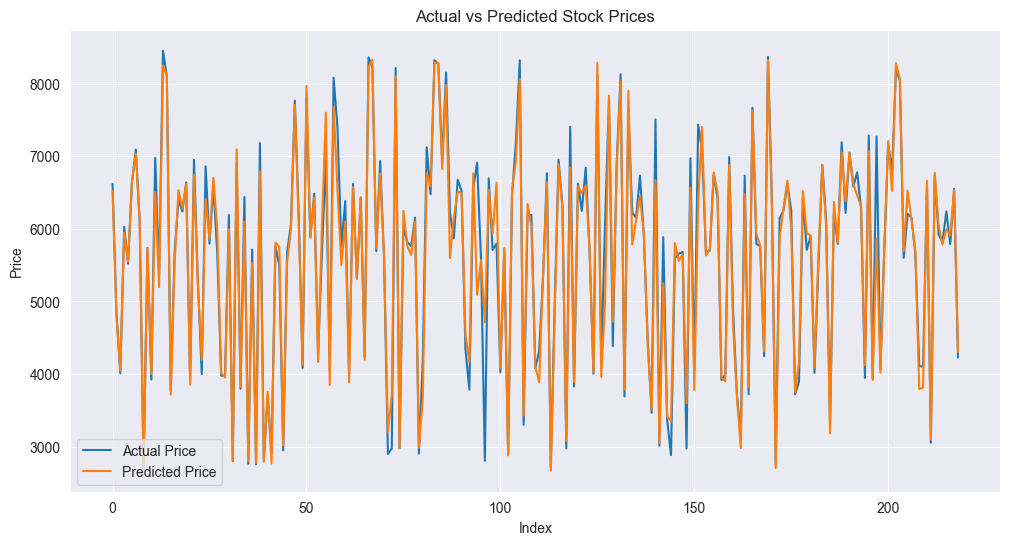

In [44]:
# Visualisation of prediction vs actual. Yes, overfit
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

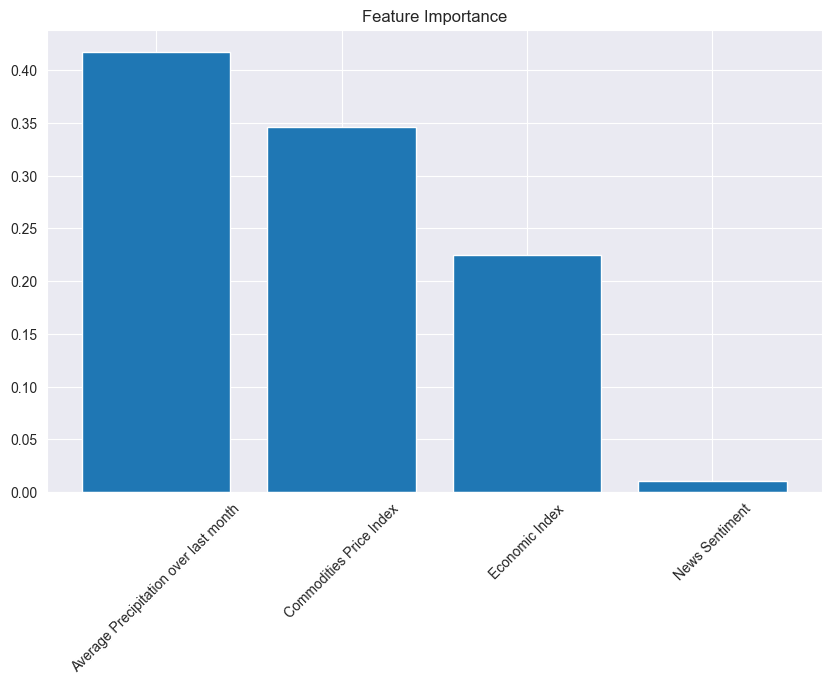

In [45]:
#visualise how important each feature was to the prediction
#clearly forward EPS. Weather, news and economic indicators irrelevant.

importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [28]:
#we know the data had some issues with the preciptiation, economic index and news sentiment. Given they're irrelevant, drop them. Create df fresh from the original again
df = data.copy()
df = df.dropna(subset=['Stock Market'])



In [29]:
#repeat the handling
df = handle_outliers(df)

Number of outliers per column:
Stock Market                             0
RSI                                      0
News Sentiment                           0
Forward EPS Estimate                     0
Economic Index                           5
Commodities Price Index                  0
Average Precipitation over last month    0
dtype: int64


In [46]:
df['Return'] = df['Stock Market'].pct_change()
for lag in range(1, 6):
    df[f'Return_Lag_{lag}'] = df['Return'].shift(lag)

df['Return_MA3'] = df['Return'].rolling(3).mean()
df['Return_MA5'] = df['Return'].rolling(5).mean()

for feature in features:
    df[f'{feature}_lag'] = df[feature].shift(lag)

features = df.select_dtypes(include=[np.number])
features.drop(columns=['Return', 'Stock Market'])

for feature in features:
    df[f'{feature}_correlation'] = df['Return'].rolling(window=5).corr(df[feature])


In [48]:
print(df.head(10))

        Date  Stock Market        RSI  News Sentiment  Forward EPS Estimate  \
0 2021-01-03   4242.420000  46.126890        0.876508             98.766789   
1 2021-01-04   4273.244631  47.571871        0.851152             98.513477   
2 2021-01-05   4227.213662  48.352360       -0.027567             98.712708   
3 2021-01-06   4244.258310  47.783879        0.459922             98.703704   
4 2021-01-07   4258.035994  46.182124        0.766275             98.720092   
5 2021-01-08   4258.035994  46.182124        0.087397             98.720092   
6 2021-01-09   4258.035994  46.182124       -0.504380             98.720092   
7 2021-01-10   4250.788235  48.038157        0.392650             98.537603   
8 2021-01-11   4187.765157  47.197082        0.548611             98.156279   
9 2021-01-12   4148.368969  46.869443        0.098358             98.278555   

   Economic Index  Commodities Price Index  \
0        2.739300               149.127680   
1        0.199946               142.13

In [51]:
print(df.describe())

                      Date  Stock Market          RSI  News Sentiment  \
count                 1093   1093.000000  1093.000000     1093.000000   
mean   2022-07-03 00:00:00   5566.725181    41.808641        0.009686   
min    2021-01-03 00:00:00   2683.178632    13.920675       -0.995423   
25%    2021-10-03 00:00:00   4131.133258    26.939827       -0.467076   
50%    2022-07-03 00:00:00   5833.983575    33.614575        0.009668   
75%    2023-04-02 00:00:00   6677.311697    57.646682        0.499455   
max    2023-12-31 00:00:00   8496.633412    89.624027        0.997685   
std                    NaN   1534.559101    20.038131        0.578475   

       Forward EPS Estimate  Economic Index  Commodities Price Index  \
count           1093.000000     1093.000000              1093.000000   
mean             165.356242       10.225986               246.757649   
min               98.156279      -21.043973               133.545217   
25%              122.539404        0.367333           

E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
E:\PycharmProjects\TradingExam\.venv\Lib\site-packages\numpy\l

In [49]:
X = df.drop(columns=['Return', 'Stock Market'])
y = df['Return']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error: %.3f" % mse)
print("R-squared: %.3f" % r2)

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Date: datetime64[ns]

In [27]:
# Drop low-importance features and retrain
low_importance_features = importance_df[importance_df['Importance'] < 0.05]['Feature'].tolist()
print("Dropping low-importance features:", low_importance_features)

# Filter remaining features
X = df[features]
X = X.drop(columns=low_importance_features)
Y = df['Stock Market']

# Retrain with reduced features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Re-evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Updated Mean Squared Error:", mse)
print("Updated R-Squared:", r2)

#0.989 R-Squared. Losses from overfit and stock weekened duplication. Still overfit

Dropping low-importance features: ['News Sentiment']
Updated Mean Squared Error: 962680.1037595007
Updated R-Squared: 0.5707899931393008


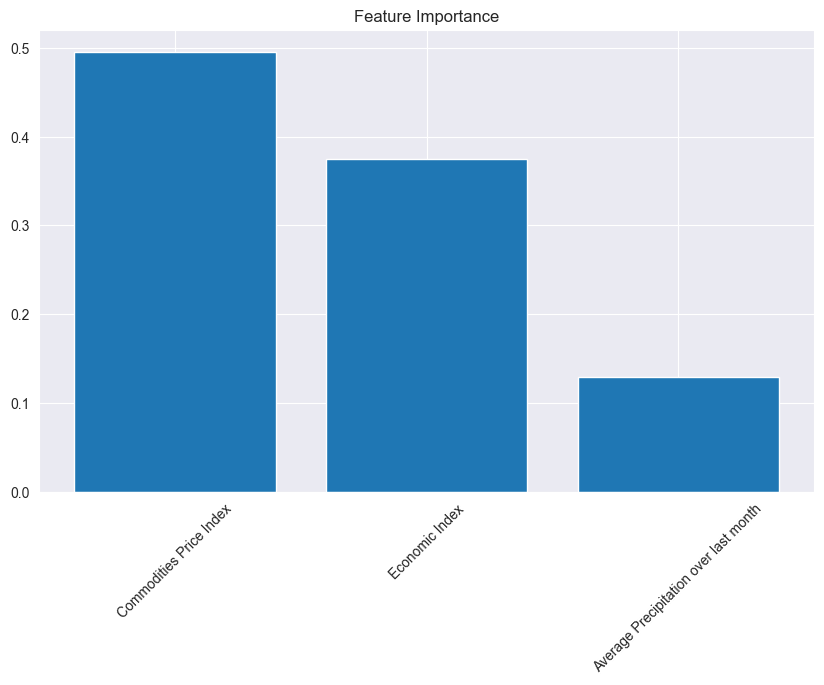

In [28]:
#Note here that RSI wasn't important but was correlated - we'll come back to that
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

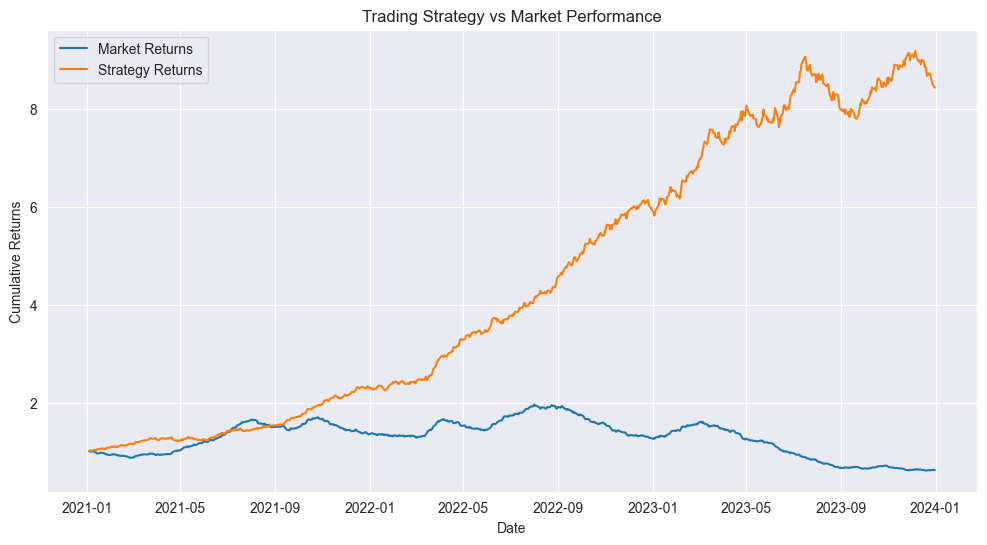

Total Strategy Return: 743.2620176287411 %
Total Market Return: -37.955678840229865 %


In [29]:
# Generate Trading Signals. Basically with this overfit accuracy, we can predict the future perfectly. Clearly unrealistic
df['Predicted'] = model.predict(X)  # Predict for entire dataset
df['Signal'] = np.where(df['Predicted'].shift(1) < df['Predicted'], 1, -1)  # Buy/Sell Signal
df['Daily_Return'] = np.log(df['Stock Market']/df['Stock Market'].shift(1))

# Calculate Strategy Returns
df['Strategy_Return'] = df['Signal'] * df['Daily_Return']

# Cumulative Returns for Strategy vs Market
cumulative_market = (1 + df['Daily_Return']).cumprod()
cumulative_strategy = (1 + df['Strategy_Return']).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], cumulative_market, label='Market Returns')
plt.plot(df['Date'], cumulative_strategy, label='Strategy Returns')
plt.title('Trading Strategy vs Market Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Performance Metrics
total_return_strategy = cumulative_strategy.iloc[-1] - 1
total_return_market = cumulative_market.iloc[-1] - 1

print("Total Strategy Return:", total_return_strategy * 100, "%")
print("Total Market Return:", total_return_market * 100, "%")

#9354% return. We could retire. Clearly this is nonsense, need a different approach not use ML.

In [24]:
#change approach from ML to technical analysis. Going to do a conservative momentum + mean reversion to buy when short moving average crossed long moving average and RSI is oversold (short vice versa). We can be 0 position in this strat

# Optimize SMA and RSI thresholds (this is overfitting too but did it to show ability)
best_sma_short = 20
best_sma_long = 50
best_rsi_overbought = 70
best_rsi_oversold = 30
best_sharpe_ratio = -np.inf

#create a backtest loop using sharpe ratio as measure for optimal SMA short/long, RSI overbought/sold. Takes less than 2secs to run
for sma_short in range(10, 51, 10):
    for sma_long in range(50, 201, 50):
        for rsi_overbought in range(60, 81, 5):
            for rsi_oversold in range(20, 41, 5):
                # Calculate SMAs
                df['SMA_Short'] = df['Stock Market'].rolling(window=sma_short).mean()
                df['SMA_Long'] = df['Stock Market'].rolling(window=sma_long).mean()

                # Drop rows with NaN caused by rolling windows
                temp_data = df.dropna().copy()

                # Generate signals based on combined SMA and RSI conditions
                #buy when oversold and short crossed long
                temp_data['Signal'] = np.where((temp_data['SMA_Short'] > temp_data['SMA_Long']) & (temp_data['RSI'] < rsi_oversold), 1, 0)
                #sell when overbought and short under long MA
                temp_data['Signal'] = np.where((temp_data['SMA_Short'] < temp_data['SMA_Long']) & (temp_data['RSI'] > rsi_overbought), -1, temp_data['Signal'])
                temp_data['Position'] = temp_data['Signal'].diff()

                # Calculate returns
                temp_data['Strategy_Return'] = temp_data['Position'].shift(1) * temp_data['Stock Market'].pct_change()
                cumulative_strategy = (1 + temp_data['Strategy_Return']).cumprod()

                # Calculate Sharpe Ratio
                if temp_data['Strategy_Return'].std() == 0: #avoid divide by 0
                    sharpe_ratio = 0
                else:
                    sharpe_ratio = temp_data['Strategy_Return'].mean() / temp_data['Strategy_Return'].std()

                # Update best parameters variable to store
                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_sma_short = sma_short
                    best_sma_long = sma_long
                    best_rsi_overbought = rsi_overbought
                    best_rsi_oversold = rsi_oversold

print(f"Best SMA Short: {best_sma_short}, Best SMA Long: {best_sma_long}")
print(f"Best RSI Overbought: {best_rsi_overbought}, Best RSI Oversold: {best_rsi_oversold}")

# Final Strategy with Optimized Parameters
df['SMA_Short'] = df['Stock Market'].rolling(window=best_sma_short).mean()
df['SMA_Long'] = df['Stock Market'].rolling(window=best_sma_long).mean()
df.dropna(inplace=True)
df['Signal'] = np.where((df['SMA_Short'] > df['SMA_Long']) & (df['RSI'] < best_rsi_oversold), 1, 0)
df['Signal'] = np.where((df['SMA_Short'] < df['SMA_Long']) & (df['RSI'] > best_rsi_overbought), -1, df['Signal'])
df['Position'] = df['Signal'].diff()

# Calculate Strategy Returns
df['Daily_Return'] = df['Stock Market'].pct_change()
df['Strategy_Return'] = df['Position'].shift(1) * df['Daily_Return']
cumulative_strategy = (1 + df['Strategy_Return']).cumprod()

#there's some divide by 0 errors which aren't an issue. ran out of time to finesse


Best SMA Short: 10, Best SMA Long: 100
Best RSI Overbought: 65, Best RSI Oversold: 30


In [25]:
# Performance Metrics
print("Total Strategy Return:", (cumulative_strategy.iloc[-1] * 100).round(2), "%")
print("Total Market Return:", (total_return_market * 100).round(2), "%")

#234% return.

Total Strategy Return: 234.82 %
Total Market Return: -37.96 %


In [26]:
df[['Strategy_Return', 'Daily_Return']].std()*252*0.5

Strategy_Return    12.245505
Daily_Return       20.491924
dtype: float64

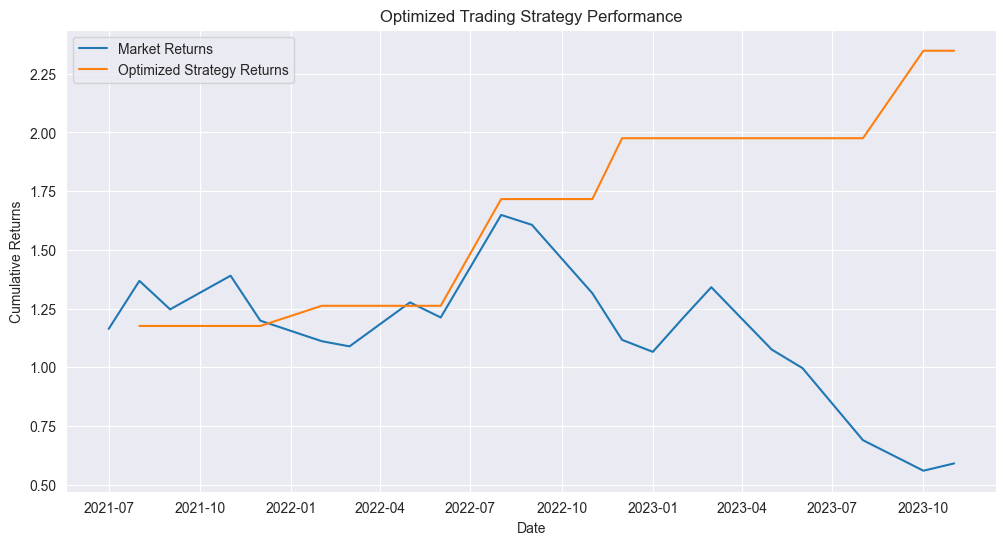

In [27]:
#plot the results against the stock
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], (1 + df['Daily_Return']).cumprod(), label='Market Returns')
plt.plot(df['Date'], cumulative_strategy, label='Optimized Strategy Returns')
plt.title('Optimized Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

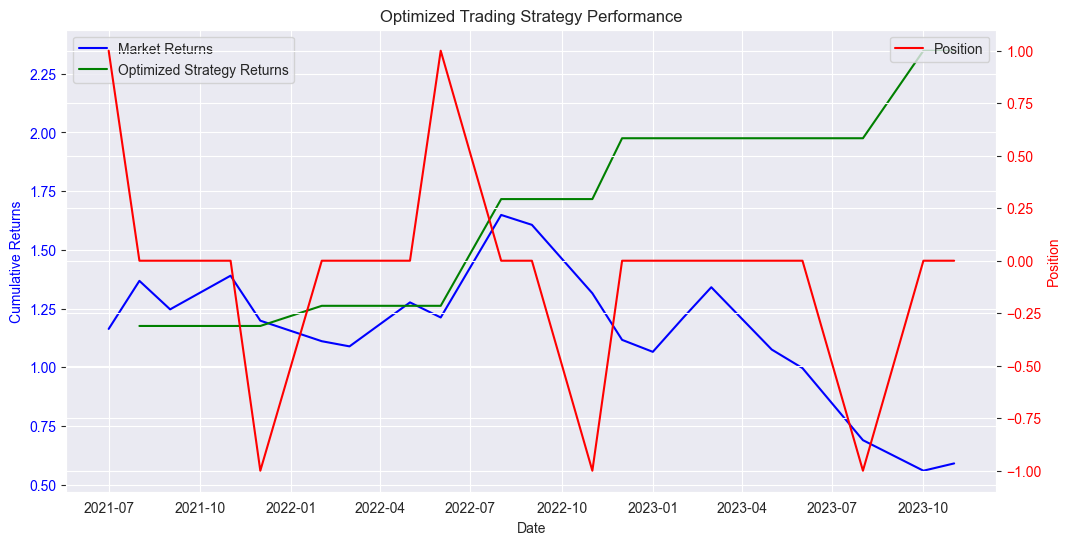

In [28]:
#great, but how did we actually make money? plot the position as a sub axis. Tuirns out we basically never owneed the stock, either being neutral or short selling
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Market Returns on the first y-axis (ax1)
ax1.plot(df['Date'], (1 + df['Daily_Return']).cumprod(), label='Market Returns', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Optimized Strategy Returns on the first y-axis (ax1)
ax1.plot(df['Date'], cumulative_strategy, label='Optimized Strategy Returns', color='green')

# Create a second y-axis (ax2) for the Position
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Position'], color='red', label='Position')
ax2.set_ylabel('Position', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and grid
plt.title('Optimized Trading Strategy Performance')
ax1.grid(True)

# Combine legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()